In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf



In [15]:
def find_dates(sids,model_cal):

	dates = sids.apply(lambda row : cf.datetime(calendar=model_cal,
									year=row.year,
									month=row.month,
									day=row.day,
									hour=row.hour
									), axis=1)
	return dates



In [16]:
# load dataset
# load data
def generate_annual_frequency(meta,rain,units_converter):
	
	# get subset of storms
	# dates = meta.date
	boolean = meta.date != 0
	print(meta.date)

	meta = meta.loc[boolean]
	rain = rain[boolean ,:,:,:]
	new_boolean = np.mean(rain,axis=(1,2,3)) != 0
	print('bool',new_boolean.shape)
	meta = meta.loc[new_boolean]
	rain = rain[new_boolean,:,:,:]
	# dates_unique=dates.drop_duplicates()
	# ndates = len(dates_unique)
	print('number of timepoints = ', meta.shape)
	sids = meta.sid
	sids_unique = sids.drop_duplicates()
	# nsids = len(sids_unique)
	# meta.date = pd.to_datetime(meta.date)
	tracks_grouped = meta.groupby(meta.sid)
	# tracks_grouped = meta.groupby(pd.Grouper(freq='M'))
	# tracks_grouped = meta.resample(rule='M', on='date')
	print(tracks_grouped)
	# total_rain = np.zeros((ndates,100,100))
	# total_rain = np.zeros((ndates))
	# i=0
	# drop_idx=[]
	# south_idx=[]
	# north_idx=[]
	daily_rains = []
	# daily_dates = []
	
	# find time frequency
	print('sids unique',sids_unique.shape)
	# for sid in sids_unique:
	# 	print(sid)
	# 	# date_for_rain = tracks_grouped.get_group(date)
	# 	rain_sid = tracks_grouped.get_group(sid)

	# 	track_dates = rain_sid.date
	# 	for track_date in track_dates:
	# 		track_daily_rain = np.sum(rain[track_dates.index,:,:,0],axis=0)*units_converter
	# 		mean_track_daily_rain = np.mean(track_daily_rain)

	# 		daily_rains.append(mean_track_daily_rain)
	# 		daily_dates.append(track_date)

	for sample in rain:
		# print(sample.shape)
		# date_for_rain = tracks_grouped.get_group(date)

		track_daily_rain = np.mean(sample)*units_converter # for cmip this is 24, for imerg it should be 8
		# they multiplied by 4 i think
		# mean_track_daily_rain = np.mean(track_daily_rain)

		daily_rains.append(track_daily_rain)
		# daily_dates.append(track_date)


		# storm_rain = rain[rain_sid.index,:,:,0]
		# print('storm_rain shape',storm_rain.shape)

		# imerg is mm/hr sampled based on ibtracs which is 3 hourly positions
		units_converter_imerg = 3

		# mswep is total rain mm/3hr sampled based on ibtracs which is 3 hourly positions interpolated from 6 hourly
		units_converter_mswep = 1

		# cmip is mm/6hr sampled every 6 hours
		units_converter_cmip = 4


		
		# total_daily_rain = np.mean(storm_rain,axis=0)*units_converter
		
		

		# total_rain[i,:,:] = total_daily_rain
		# print('shape of total_daily_rain sum',np.mean(total_daily_rain))
		# total_rain[i] = np.mean(total_daily_rain)
		# i=i+1

	
	# # get nh and sh datasets
	# composite_storm_rain_nh = composite_storm_rain[north_idx,:,:]
	# composite_storm_rain_sh = composite_storm_rain[south_idx,:,:]
	x = np.arange(-5, 300, 5)
	y = np.histogram(daily_rains,bins = x)[0]

	print(y)
	window_size = 5
	smoothed_frequencies = np.convolve(y, np.ones(window_size) / window_size, mode='same')
	y = smoothed_frequencies
	y[0] = 1
	# y[y==0] = 1
	return y,x[1:]




In [17]:
def calc_nyears(meta):
	nyears = int(meta.year[len(meta.year)-1] - meta.year[0] + 1)
	return nyears

In [18]:
def lookup(row,cal):
	# date = cf.datetime(calendar=cal,
	# 				year=row.year,
	# 				month=row.month,
	# 				day=row.day,
	# 				hour=row.hour
	# 				)
	if row.year not in range(2000,2015):
		return 0
	else:
		date = cf.datetime(calendar=cal,
						year=row.year,
						month=row.month,
						day=row.day,
						)

	# date = pd.to_datetime('year' : row.year, 'month' : row.month, 'day' = row.day)
	return date

def lookup_ibtracs(row,tracks):
	# tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
	# 					usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
	# 					parse_dates = ['ISO_TIME'],keep_default_na=False)
	boolean = (tracks.SID == row.sid) & (tracks.LAT == row.centre_lat) & (tracks.LON == row.centre_lon)
	time =  pd.to_datetime(tracks.loc[boolean].ISO_TIME)
	if list(time) == []:
		print('no',flush=True)
		date = cf.datetime(calendar='gregorian',
						year=1978,
						month=1,
						day=1,
						hour=0
						)
		return date
	else:
		time =  time.iloc[0]
		date = cf.datetime(calendar='gregorian',
						year=time.year,
						month=time.month,
						day=time.day,
						)
	return date

def find_dates_mswep(meta):
	dates = meta.apply(lookup, axis=1)
	return dates

def find_dates(meta,calendar):
	dates = meta.apply(lookup, cal = calendar, axis=1)
	return dates

def find_dates_ibtracs(meta):
	tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
						usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
						parse_dates = ['ISO_TIME'],keep_default_na=False)
	dates = meta.apply(lookup_ibtracs, tracks= tracks, axis=1)
	# dates = meta.apply(lookup_ibtracs, axis=1)
	return dates

In [19]:
# load current 1D dataset
real,inputs,pred_scalar,meta = load_tc_data(set='validation',results='ke_tracks')
# tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
# 						usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
# 						parse_dates = ['ISO_TIME'],keep_default_na=False)
# print(lookup_ibtracs(meta.iloc[0],tracks))
# dates = find_dates_ibtracs(meta)
# print(dates)
# meta['date'] = dates
meta_scalar = pd.read_csv('/user/work/al18709/tc_data_mswep_40/scalar_wgan_valid_meta_with_dates.csv')

# # load ibtracks
# tracks = pd.read_csv('/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv',
# 						usecols=['SID','LAT','LON','BASIN','NAME','SEASON', 'NATURE','ISO_TIME','USA_SSHS'],
# 						parse_dates = ['ISO_TIME'],keep_default_na=False)

# og_tracks_grouped = tracks.groupby('sid')

In [20]:
# # load original 2D WGAN
real_2,inputs_2,pred_2,meta_2,imput_og,pred_og,meta_og = load_tc_data(set='validation',results='kh_tracks')
# meta_2['date'] = find_dates_ibtracs(meta_2,'gregorian')
# meta_og['date'] = find_dates_ibtracs(meta_og,'gregorian')
real_og_x,_,_,_,_,_,pred_og_x,meta_og_x = load_tc_data(set='extreme_test',results='test')
# meta_og_x['date'] = find_dates_ibtracs(meta_og_x,'gregorian')
meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/valid_meta.csv')
meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/original_wgan_valid_meta_with_dates.csv')
# meta_og['date'] = find_dates_ibtracs(meta_og,'gregorian')
# meta_og = 
# meta_valid = pd.read_csv('/user/work/al18709/tc_data_flipped/valid_meta.csv')

In [21]:
# load imerg
imerg_rain = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_rain_NH.npy')
imerg_lats = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_lats_NH.npy')
imerg_lons = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_lons_NH.npy')
imerg_sids = pd.read_csv('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_sid_NH.csv')
print(imerg_sids.sid.shape)
meta_imerg = pd.DataFrame({'sid':imerg_sids.sid ,'centre_lat':imerg_lats[:,4], 'centre_lon':imerg_lons[:,4],'date':find_dates(imerg_sids,calendar='julian')})

(22142,)


In [22]:
# load MSWEP
# load mswep
mswep_rain = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_rain_NH.npy')
mswep_lats = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lats_NH.npy')
mswep_lons = np.load('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_lons_NH.npy')
mswep_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_sid_NH.csv')
print(mswep_sids.sid.shape)
meta_mswep = pd.DataFrame({'sid':mswep_sids.sid ,'centre_lat':mswep_lats[:,4], 'centre_lon':mswep_lons[:,4],'date':find_dates(mswep_sids,calendar='standard')})


(53183,)


In [23]:
# load HighResMIP CMCC-CM2-VHR4 historical NH
CMCC_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_NH.npy')
CMCC_hist_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lats_NH.npy')
CMCC_hist_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lons_NH.npy')
CMCC_hist_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_sid_NH.csv')
print(CMCC_hist_NH_sids.sid.shape)
indices = (CMCC_hist_NH_sids['year'] >= 2000) & (CMCC_hist_NH_sids['year'] <= 2014)
CMCC_hist_NH_sids = CMCC_hist_NH_sids[indices].reset_index()
CMCC_hist_NH_rain = CMCC_hist_NH_rain[indices]
CMCC_hist_NH_lats = CMCC_hist_NH_lats[indices]
CMCC_hist_NH_lons = CMCC_hist_NH_lons[indices]
meta_CMCC_hist_NH = pd.DataFrame({'sid':CMCC_hist_NH_sids.sid ,'centre_lat':CMCC_hist_NH_lats[:,4], 'centre_lon':CMCC_hist_NH_lons[:,4], 'date':find_dates(CMCC_hist_NH_sids,'365_day')})

# load HighResMIP CMCC-CM2-VHR4 historical SH
CMCC_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_SH.npy')
CMCC_hist_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lats_SH.npy')
CMCC_hist_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_lons_SH.npy')
CMCC_hist_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_sid_SH.csv')
print(CMCC_hist_SH_sids.sid.shape)
indices = (CMCC_hist_SH_sids['year'] >= 2000) & (CMCC_hist_SH_sids['year'] <= 2014)
CMCC_hist_SH_sids = CMCC_hist_SH_sids[indices].reset_index()
CMCC_hist_SH_rain = CMCC_hist_SH_rain[indices]
CMCC_hist_SH_lats = CMCC_hist_SH_lats[indices]
CMCC_hist_SH_lons = CMCC_hist_SH_lons[indices]
meta_CMCC_hist_SH = pd.DataFrame({'sid':CMCC_hist_SH_sids.sid ,'centre_lat':CMCC_hist_SH_lats[:,4], 'centre_lon':CMCC_hist_SH_lons[:,4], 'date':find_dates(CMCC_hist_SH_sids,'365_day')})

# load HighResMIP EC-EARTH-3P-HR  historical NH
ecearthhr_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_rain_NH.npy')
ecearthhr_hist_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lats_NH.npy')
ecearthhr_hist_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lons_NH.npy')
ecearthhr_hist_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_sid_NH.csv')
print(ecearthhr_hist_NH_sids.sid.shape)
indices = (ecearthhr_hist_NH_sids['year'] >= 2000) & (ecearthhr_hist_NH_sids['year'] <= 2014)
ecearthhr_hist_NH_sids = ecearthhr_hist_NH_sids[indices].reset_index()
ecearthhr_hist_NH_rain = ecearthhr_hist_NH_rain[indices]
ecearthhr_hist_NH_lats = ecearthhr_hist_NH_lats[indices]
ecearthhr_hist_NH_lons = ecearthhr_hist_NH_lons[indices]
meta_ecearthhr_hist_NH = pd.DataFrame({'sid':ecearthhr_hist_NH_sids.sid ,'centre_lat':ecearthhr_hist_NH_lats[:,4], 'centre_lon':ecearthhr_hist_NH_lons[:,4], 'year':ecearthhr_hist_NH_sids.year})

# load HighResMIP EC-EARTH-3P-HR historical SH
ecearthhr_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_rain_SH.npy')
ecearthhr_hist_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lats_SH.npy')
ecearthhr_hist_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_lons_SH.npy')
ecearthhr_hist_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3P-HR/storm_rain/historical/storm_sid_SH.csv')
print(ecearthhr_hist_SH_sids.sid.shape)
indices = (ecearthhr_hist_SH_sids['year'] >= 2000) & (ecearthhr_hist_SH_sids['year'] <= 2014)
ecearthhr_hist_SH_sids = ecearthhr_hist_SH_sids[indices].reset_index()
ecearthhr_hist_SH_rain = ecearthhr_hist_SH_rain[indices]
ecearthhr_hist_SH_lats = ecearthhr_hist_SH_lats[indices]
ecearthhr_hist_SH_lons = ecearthhr_hist_SH_lons[indices]
meta_ecearthhr_hist_SH = pd.DataFrame({'sid':ecearthhr_hist_SH_sids.sid ,'centre_lat':ecearthhr_hist_SH_lats[:,4], 'centre_lon':ecearthhr_hist_SH_lons[:,4], 'year':ecearthhr_hist_SH_sids.year})

# load HighResMIP HadGEM3-GC31-HM   historical NH
hadgem_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_NH.npy')
hadgem_hist_NH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lats_NH.npy')
hadgem_hist_NH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lons_NH.npy')
hadgem_hist_NH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_sid_NH.csv')
print(hadgem_hist_NH_sids.sid.shape)
indices = (hadgem_hist_NH_sids['year'] >= 2000) & (hadgem_hist_NH_sids['year'] <= 2014)
hadgem_hist_NH_sids = hadgem_hist_NH_sids[indices].reset_index()
hadgem_hist_NH_rain = hadgem_hist_NH_rain[indices]
hadgem_hist_NH_lats = hadgem_hist_NH_lats[indices]
hadgem_hist_NH_lons = hadgem_hist_NH_lons[indices]
meta_hadgem_hist_NH = pd.DataFrame({'sid':hadgem_hist_NH_sids.sid ,'centre_lat':hadgem_hist_NH_lats[:,4], 'centre_lon':hadgem_hist_NH_lons[:,4],'date':find_dates(hadgem_hist_NH_sids,'360_day')})

# # load HighResMIP HadGEM3-GC31-HM  historical SH
hadgem_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_SH.npy')
hadgem_hist_SH_lats = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lats_SH.npy')
hadgem_hist_SH_lons = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_lons_SH.npy')
hadgem_hist_SH_sids = pd.read_csv('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_sid_SH.csv')
print(hadgem_hist_SH_sids.sid.shape)
indices = (hadgem_hist_SH_sids['year'] >= 2000) & (hadgem_hist_SH_sids['year'] <= 2014)
hadgem_hist_SH_sids = hadgem_hist_SH_sids[indices].reset_index()
hadgem_hist_SH_rain = hadgem_hist_SH_rain[indices]
hadgem_hist_SH_lats = hadgem_hist_SH_lats[indices]
hadgem_hist_SH_lons = hadgem_hist_SH_lons[indices]
meta_hadgem_hist_SH = pd.DataFrame({'sid':hadgem_hist_SH_sids.sid ,'centre_lat':hadgem_hist_SH_lats[:,4], 'centre_lon':hadgem_hist_SH_lons[:,4], 'date':find_dates(hadgem_hist_SH_sids,'360_day')})


(5236,)
(2366,)
(131,)
(62,)
(852,)
(195,)


In [24]:
# load CMIP6 historical dataset 
miroc6_hist_rain = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_NH.npy')
miroc6_hist_lats = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lats_NH.npy')
miroc6_hist_lons = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lons_NH.npy')
miroc6_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_sid_NH.csv')
indices = (miroc6_hist_sids['year'] >= 2000) & (miroc6_hist_sids['year'] <= 2014)
miroc6_hist_sids = miroc6_hist_sids[indices].reset_index()
miroc6_hist_rain = miroc6_hist_rain[indices]
miroc6_hist_lats = miroc6_hist_lats[indices]
miroc6_hist_lons = miroc6_hist_lons[indices]
meta_miroc6_hist = pd.DataFrame({'sid':miroc6_hist_sids.sid ,'centre_lat':miroc6_hist_lats[:,4], 'centre_lon':miroc6_hist_lons[:,4], 'date':find_dates(miroc6_hist_sids,'gregorian')})

miroc6_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_SH.npy')
miroc6_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lats_SH.npy')
miroc6_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_lons_SH.npy')
miroc6_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_sid_SH.csv')
indices = (miroc6_hist_sids_SH['year'] >= 2000) & (miroc6_hist_sids_SH['year'] <= 2014)
miroc6_hist_sids_SH = miroc6_hist_sids_SH[indices].reset_index()
miroc6_hist_rain_SH = miroc6_hist_rain_SH[indices]
miroc6_hist_lats_SH = miroc6_hist_lats_SH[indices]
miroc6_hist_lons_SH = miroc6_hist_lons_SH[indices]
meta_miroc6_hist_SH = pd.DataFrame({'sid':miroc6_hist_sids_SH.sid ,'centre_lat':miroc6_hist_lats_SH[:,4], 'centre_lon':miroc6_hist_lons_SH[:,4], 'date':find_dates(miroc6_hist_sids_SH,'gregorian')})

# CMIP6 MPI-ESM1-2-LR
mpi_hist_rain = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_NH.npy')
mpi_hist_lats = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lats_NH.npy')
mpi_hist_lons = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lons_NH.npy')
mpi_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_sid_NH.csv')
indices = (mpi_hist_sids['year'] >= 2000) & (mpi_hist_sids['year'] <= 2014)
mpi_hist_sids = mpi_hist_sids[indices].reset_index()
mpi_hist_rain = mpi_hist_rain[indices]
mpi_hist_lats = mpi_hist_lats[indices]
mpi_hist_lons = mpi_hist_lons[indices]
meta_mpi_hist = pd.DataFrame({'sid':mpi_hist_sids.sid ,'centre_lat':mpi_hist_lats[:,4], 'centre_lon':mpi_hist_lons[:,4], 'date':find_dates(mpi_hist_sids,'proleptic_gregorian')})

mpi_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_SH.npy')
mpi_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lats_SH.npy')
mpi_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_lons_SH.npy')
mpi_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_sid_SH.csv')
indices = (mpi_hist_sids_SH['year'] >= 2000) & (mpi_hist_sids_SH['year'] <= 2014)
mpi_hist_sids_SH = mpi_hist_sids_SH[indices].reset_index()
mpi_hist_rain_SH = mpi_hist_rain_SH[indices]
mpi_hist_lats_SH = mpi_hist_lats_SH[indices]
mpi_hist_lons_SH = mpi_hist_lons_SH[indices]
meta_mpi_hist_SH = pd.DataFrame({'sid':mpi_hist_sids_SH.sid ,'centre_lat':mpi_hist_lats_SH[:,4], 'centre_lon':mpi_hist_lons_SH[:,4], 'date':find_dates(mpi_hist_sids_SH,'proleptic_gregorian')})

# CMIP6 Noresm
noresm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_NH.npy')
noresm_hist_lats = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lats_NH.npy')
noresm_hist_lons = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lons_NH.npy')
noresm_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_sid_NH.csv')
indices = (noresm_hist_sids['year'] >= 2000) & (noresm_hist_sids['year'] <= 2014)
noresm_hist_sids = noresm_hist_sids[indices].reset_index()
noresm_hist_rain = noresm_hist_rain[indices]
noresm_hist_lats = noresm_hist_lats[indices]
noresm_hist_lons = noresm_hist_lons[indices]
meta_noresm_hist = pd.DataFrame({'sid':noresm_hist_sids.sid ,'centre_lat':noresm_hist_lats[:,4], 'centre_lon':noresm_hist_lons[:,4], 'date':find_dates(noresm_hist_sids,'noleap')})

noresm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_SH.npy')
noresm_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lats_SH.npy')
noresm_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_lons_SH.npy')
noresm_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_sid_SH.csv')
indices = (noresm_hist_sids_SH['year'] >= 2000) & (noresm_hist_sids_SH['year'] <= 2014)
noresm_hist_sids_SH = noresm_hist_sids_SH[indices].reset_index()
noresm_hist_rain_SH = noresm_hist_rain_SH[indices]
noresm_hist_lats_SH = noresm_hist_lats_SH[indices]
noresm_hist_lons_SH = noresm_hist_lons_SH[indices]
meta_noresm_hist_SH = pd.DataFrame({'sid':noresm_hist_sids_SH.sid ,'centre_lat':noresm_hist_lats_SH[:,4], 'centre_lon':noresm_hist_lons_SH[:,4], 'date':find_dates(noresm_hist_sids,'noleap')})

# CMIP6 IPSL
ipsl_hist_rain = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_NH.npy')
ipsl_hist_lats = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lats_NH.npy')
ipsl_hist_lons = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lons_NH.npy')
ipsl_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_sid_NH.csv')
indices = (ipsl_hist_sids['year'] >= 2000) & (ipsl_hist_sids['year'] <= 2014)
ipsl_hist_sids = ipsl_hist_sids[indices].reset_index()
ipsl_hist_rain = ipsl_hist_rain[indices]
ipsl_hist_lats = ipsl_hist_lats[indices]
ipsl_hist_lons = ipsl_hist_lons[indices]
meta_ipsl_hist = pd.DataFrame({'sid':ipsl_hist_sids.sid ,'centre_lat':ipsl_hist_lats[:,4], 'centre_lon':ipsl_hist_lons[:,4], 'date':find_dates(ipsl_hist_sids,'gregorian')})

ipsl_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_SH.npy')
ipsl_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lats_SH.npy')
ipsl_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_lons_SH.npy')
ipsl_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_sid_SH.csv')
indices = (ipsl_hist_sids_SH['year'] >= 2000) & (ipsl_hist_sids_SH['year'] <= 2014)
ipsl_hist_sids_SH = ipsl_hist_sids_SH[indices].reset_index()
ipsl_hist_rain_SH = ipsl_hist_rain_SH[indices]
ipsl_hist_lats_SH = ipsl_hist_lats_SH[indices]
ipsl_hist_lons_SH = ipsl_hist_lons_SH[indices]
meta_ipsl_hist_SH = pd.DataFrame({'sid':ipsl_hist_sids_SH.sid ,'centre_lat':ipsl_hist_lats_SH[:,4], 'centre_lon':ipsl_hist_lons_SH[:,4], 'date':find_dates(ipsl_hist_sids_SH,'gregorian')})

# CMIP6 mri
mri_hist_rain = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_NH.npy')
mri_hist_lats = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lats_NH.npy')
mri_hist_lons = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lons_NH.npy')
mri_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_sid_NH.csv')
indices = (mri_hist_sids['year'] >= 2000) & (mri_hist_sids['year'] <= 2014)
mri_hist_sids = mri_hist_sids[indices].reset_index()
mri_hist_rain = mri_hist_rain[indices]
mri_hist_lats = mri_hist_lats[indices]
mri_hist_lons = mri_hist_lons[indices]
meta_mri_hist = pd.DataFrame({'sid':mri_hist_sids.sid ,'centre_lat':mri_hist_lats[:,4], 'centre_lon':mri_hist_lons[:,4], 'date':find_dates(mri_hist_sids,'proleptic_gregorian')})

mri_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_SH.npy')
mri_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lats_SH.npy')
mri_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_lons_SH.npy')
mri_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_sid_SH.csv')
indices = (mri_hist_sids_SH['year'] >= 2000) & (mri_hist_sids_SH['year'] <= 2014)
mri_hist_sids_SH = mri_hist_sids_SH[indices].reset_index()
mri_hist_rain_SH = mri_hist_rain_SH[indices]
mri_hist_lats_SH = mri_hist_lats_SH[indices]
mri_hist_lons_SH = mri_hist_lons_SH[indices]
meta_mri_hist_SH = pd.DataFrame({'sid':mri_hist_sids_SH.sid ,'centre_lat':mri_hist_lats_SH[:,4], 'centre_lon':mri_hist_lons_SH[:,4], 'date':find_dates(mri_hist_sids_SH,'proleptic_gregorian')})

# CMIP6 EC-Earth
ecearth_hist_rain = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_NH.npy')
ecearth_hist_lats = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lats_NH.npy')
ecearth_hist_lons = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lons_NH.npy')
ecearth_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_sid_NH.csv')
indices = (ecearth_hist_sids['year'] >= 2000) & (ecearth_hist_sids['year'] <= 2014)
ecearth_hist_sids = ecearth_hist_sids[indices].reset_index()
ecearth_hist_rain = ecearth_hist_rain[indices]
ecearth_hist_lats = ecearth_hist_lats[indices]
ecearth_hist_lons = ecearth_hist_lons[indices]
meta_ecearth_hist = pd.DataFrame({'sid':ecearth_hist_sids.sid ,'centre_lat':ecearth_hist_lats[:,4], 'centre_lon':ecearth_hist_lons[:,4], 'date':find_dates(ecearth_hist_sids,'proleptic_gregorian')})

ecearth_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_SH.npy')
ecearth_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lats_SH.npy')
ecearth_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_lons_SH.npy')
ecearth_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_sid_SH.csv')
indices = (ecearth_hist_sids_SH['year'] >= 2000) & (ecearth_hist_sids_SH['year'] <= 2014)
ecearth_hist_sids_SH = ecearth_hist_sids_SH[indices].reset_index()
ecearth_hist_rain_SH = ecearth_hist_rain_SH[indices]
ecearth_hist_lats_SH = ecearth_hist_lats_SH[indices]
ecearth_hist_lons_SH = ecearth_hist_lons_SH[indices]
meta_ecearth_hist_SH = pd.DataFrame({'sid':ecearth_hist_sids_SH.sid ,'centre_lat':ecearth_hist_lats_SH[:,4], 'centre_lon':ecearth_hist_lons_SH[:,4], 'date':find_dates(ecearth_hist_sids,'proleptic_gregorian')})

# CMIP6 CMCC_LR
cmcclr_hist_rain = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_NH.npy')
cmcclr_hist_lats = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lats_NH.npy')
cmcclr_hist_lons = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lons_NH.npy')
cmcclr_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_sid_NH.csv')
indices = (cmcclr_hist_sids['year'] >= 2000) & (cmcclr_hist_sids['year'] <= 2014)
cmcclr_hist_sids = cmcclr_hist_sids[indices].reset_index()
cmcclr_hist_rain = cmcclr_hist_rain[indices]
cmcclr_hist_lats = cmcclr_hist_lats[indices]
cmcclr_hist_lons = cmcclr_hist_lons[indices]
meta_cmcclr_hist = pd.DataFrame({'sid':cmcclr_hist_sids.sid ,'centre_lat':cmcclr_hist_lats[:,4], 'centre_lon':cmcclr_hist_lons[:,4], 'date':find_dates(cmcclr_hist_sids,'365_day')})

cmcclr_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_SH.npy')
cmcclr_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lats_SH.npy')
cmcclr_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_lons_SH.npy')
cmcclr_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_sid_SH.csv')
indices = (cmcclr_hist_sids_SH['year'] >= 2000) & (cmcclr_hist_sids_SH['year'] <= 2014)
cmcclr_hist_sids_SH = cmcclr_hist_sids_SH[indices].reset_index()
cmcclr_hist_rain_SH = cmcclr_hist_rain_SH[indices]
cmcclr_hist_lats_SH = cmcclr_hist_lats_SH[indices]
cmcclr_hist_lons_SH = cmcclr_hist_lons_SH[indices]
meta_cmcclr_hist_SH = pd.DataFrame({'sid':cmcclr_hist_sids_SH.sid ,'centre_lat':cmcclr_hist_lats_SH[:,4], 'centre_lon':cmcclr_hist_lons_SH[:,4], 'date':find_dates(cmcclr_hist_sids_SH,'365_day')})

# CMIP6 NESM3
nesm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_NH.npy')
nesm_hist_lats = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lats_NH.npy')
nesm_hist_lons = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lons_NH.npy')
nesm_hist_sids = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_sid_NH.csv')
indices = (nesm_hist_sids['year'] >= 2000) & (nesm_hist_sids['year'] <= 2014)
nesm_hist_sids = nesm_hist_sids[indices].reset_index()
nesm_hist_rain = nesm_hist_rain[indices]
nesm_hist_lats = nesm_hist_lats[indices]
nesm_hist_lons = nesm_hist_lons[indices]
meta_nesm_hist = pd.DataFrame({'sid':nesm_hist_sids.sid ,'centre_lat':nesm_hist_lats[:,4], 'centre_lon':nesm_hist_lons[:,4], 'date':find_dates(nesm_hist_sids,'standard')})

nesm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_SH.npy')
nesm_hist_lats_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lats_SH.npy')
nesm_hist_lons_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_lons_SH.npy')
nesm_hist_sids_SH = pd.read_csv('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_sid_SH.csv')
indices = (nesm_hist_sids_SH['year'] >= 2000) & (nesm_hist_sids_SH['year'] <= 2014)
nesm_hist_sids_SH = nesm_hist_sids_SH[indices].reset_index()
nesm_hist_rain_SH = nesm_hist_rain_SH[indices]
nesm_hist_lats_SH = nesm_hist_lats_SH[indices]
nesm_hist_lons_SH = nesm_hist_lons_SH[indices]
meta_nesm_hist_SH = pd.DataFrame({'sid':nesm_hist_sids_SH.sid ,'centre_lat':nesm_hist_lats_SH[:,4], 'centre_lon':nesm_hist_lons_SH[:,4], 'date':find_dates(nesm_hist_sids_SH,'standard')})

# load trmm
trmm_rain = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_rain_NH.npy')
trmm_lats = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_lats_NH.npy')
trmm_lons = np.load('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_lons_NH.npy')
trmm_sids = pd.read_csv('/user/home/al18709/work/CMIP6/TRMM/storm_rain/storm_sid_NH.csv')
print(imerg_sids.sid.shape)
meta_trmm = pd.DataFrame({'sid':trmm_sids.sid ,'centre_lat':trmm_lats[:,4], 'centre_lon':trmm_lons[:,4], 'hour':trmm_sids.hour, 'year':trmm_sids.year})


(22142,)


In [25]:
print(meta_imerg.shape)
print(meta_mswep.shape)

boolean = meta_imerg.date != 0
meta = meta_imerg.loc[boolean]

print(meta.shape)

boolean = meta_mswep.date != 0
meta = meta_mswep.loc[boolean]

print(meta.shape)

print(meta)

(22142, 4)
(53183, 4)
(14553, 4)
(18121, 4)
                 sid  centre_lat  centre_lon                 date
27433  2000003S13082  -20.450001   70.150009  2000-01-08 00:00:00
27434  2000003S13082  -20.750004   69.450012  2000-01-08 00:00:00
27435  2000003S13082  -21.049999   68.750000  2000-01-08 00:00:00
27436  2000003S13082  -21.250004   68.050003  2000-01-08 00:00:00
27437  2000003S13082  -21.350002   67.350006  2000-01-08 00:00:00
...              ...         ...         ...                  ...
45549  2014356S08101  -23.250004   83.949997  2014-12-30 00:00:00
45550  2014356S08101  -23.549999   83.550003  2014-12-30 00:00:00
45551  2014356S08101  -23.850002   83.250015  2014-12-31 00:00:00
45552  2014356S08101  -24.250004   82.949997  2014-12-31 00:00:00
45553  2014356S08101  -24.549999   82.449997  2014-12-31 00:00:00

[18121 rows x 4 columns]


In [26]:
# Obs and WGAN
# total_rain,dates = generate_annual_frequency(meta,real,1)
# total_rain_x,dates_x = generate_annual_frequency(meta_og_x,np.expand_dims(real_og_x,axis=-1),1)
total_rain_wgan,dates_wgan = generate_annual_frequency(meta_scalar,pred_scalar,8)
total_rain_wgan_og,dates_wgan_og = generate_annual_frequency(meta_og,pred_og,8)
# total_rain_og,dates_og = generate_annual_frequency(meta_og,pred_og,1)
# total_rain_og_x,dates_og_x = generate_annual_frequency(meta_og_x,pred_og_x,1)

# imerg
# set imerg=True?
# i don't think we need to multiply rain by 3 hours maybe? because its rain rate over the hour so we assume it rains at the same rate for 3 or 6 hours depending on the track?
# I think the storm track is handling the fact its rain rate and not accumulated rainfall here.
# imerg_total_rain,imerg_dates = generate_annual_frequency(meta_imerg,np.expand_dims(imerg_rain,axis=-1),3)
# nyears_imerg = calc_nyears(meta_imerg)
total_rain_imerg,dates_imerg = generate_annual_frequency(meta_imerg,np.expand_dims(imerg_rain,axis=-1),24) # this might be 24 not 8

total_rain_mswep,dates_mswep = generate_annual_frequency(meta_mswep,np.expand_dims(mswep_rain,axis=-1),8)


# because rain was originally in precip flux, converted to mm/6hr with rain_data = rain_data * 86400/4 
# so multiply by 4 to get mm/day
cmip_converter = 4
# trmm
# composite_trmm_NH,composite_trmm_SH,nstorms_trmm_nh,nstorms_trmm_sh = generate_annual_frequency(meta_trmm,np.expand_dims(trmm_rain,axis=-1),ibtracks=og_tracks_grouped)
# nyears_trmm = calc_nyears(meta_trmm)

# HighResMIP
total_rain_CMCC_nh,dates_CMCC_nh = generate_annual_frequency(meta_CMCC_hist_NH,np.expand_dims(CMCC_hist_NH_rain,axis=-1),cmip_converter)
# nyears_CMCC_hist_NH = calc_nyears(meta_CMCC_hist_NH)
total_rain_CMCC_sh,dates_CMCC_sh = generate_annual_frequency(meta_CMCC_hist_SH,np.expand_dims(CMCC_hist_SH_rain,axis=-1),cmip_converter)
# nyears_CMCC_hist_SH = calc_nyears(meta_CMCC_hist_SH)

# total_rain_ecearthhr_nh,dates_exearthhr_nh = generate_annual_frequency(meta_ecearthhr_hist_NH,np.expand_dims(ecearthhr_hist_NH_rain,axis=-1),cmip_converter)
# nyears_ecearthhr_hist_NH = calc_nyears(meta_ecearthhr_hist_NH)
# total_rain_ecearthhr_sh,dates_ecearthhr_sh = generate_annual_frequency(meta_ecearthhr_hist_SH,np.expand_dims(ecearthhr_hist_SH_rain,axis=-1),cmip_converter)
# nyears_ecearthhr_hist_SH = calc_nyears(meta_ecearthhr_hist_SH)

total_rain_hadgem_nh,dates_hadgem_nh = generate_annual_frequency(meta_hadgem_hist_NH,np.expand_dims(hadgem_hist_NH_rain,axis=-1),cmip_converter)
# nyears_hadgem_hist_NH = calc_nyears(meta_hadgem_hist_NH)
total_rain_hadgem_sh,dates_hadgem_sh = generate_annual_frequency(meta_hadgem_hist_SH,np.expand_dims(hadgem_hist_SH_rain,axis=-1),cmip_converter)
# nyears_ecearthhr_hist_SH = calc_nyears(meta_ecearthhr_hist_SH)


# CMIP6
total_rain_miroc6_nh,dates_miroc6_nh = generate_annual_frequency(meta_miroc6_hist,np.expand_dims(miroc6_hist_rain,axis=-1),cmip_converter)
# nyears_miroc6_hist_nh = calc_nyears(meta_miroc6_hist)
total_rain_miroc6_sh,dates_miroc6_sh = generate_annual_frequency(meta_miroc6_hist_SH,np.expand_dims(miroc6_hist_rain_SH,axis=-1),cmip_converter)
# nyears_miroc6_hist_sh = calc_nyears(meta_miroc6_hist_SH)

total_rain_mpi_nh,dates_mpi_nh = generate_annual_frequency(meta_mpi_hist,np.expand_dims(mpi_hist_rain,axis=-1),cmip_converter)
# nyears_mpi_hist_nh = calc_nyears(meta_mpi_hist)
total_rain_mpi_sh,dates_mpi_sh = generate_annual_frequency(meta_mpi_hist_SH,np.expand_dims(mpi_hist_rain_SH,axis=-1),cmip_converter)
# nyears_mpi_hist_sh = calc_nyears(meta_mpi_hist_SH)

total_rain_noresm_nh,dates_noresm_nh = generate_annual_frequency(meta_noresm_hist,np.expand_dims(noresm_hist_rain,axis=-1),cmip_converter)
# nyears_noresm_hist_nh = calc_nyears(meta_noresm_hist)
total_rain_noresm_nh,dates_noresm_nh = generate_annual_frequency(meta_noresm_hist_SH,np.expand_dims(noresm_hist_rain_SH,axis=-1),cmip_converter)
# nyears_noresm_hist_sh = calc_nyears(meta_noresm_hist_SH)

total_rain_nesm_nh,dates_nesm_nh = generate_annual_frequency(meta_nesm_hist,np.expand_dims(nesm_hist_rain,axis=-1),cmip_converter)
# nyears_nesm_hist_nh = calc_nyears(meta_nesm_hist)
total_rain_nesm_sh,dates_nesm_sh = generate_annual_frequency(meta_nesm_hist_SH,np.expand_dims(nesm_hist_rain_SH,axis=-1),cmip_converter)
# nyears_nesm_hist_sh = calc_nyears(meta_nesm_hist_SH)

total_rain_ipsl_nh,dates_ipsl_nh = generate_annual_frequency(meta_ipsl_hist,np.expand_dims(ipsl_hist_rain,axis=-1),cmip_converter)
# nyears_ipsl_hist_nh = calc_nyears(meta_ipsl_hist)
total_rain_ipsl_sh,dates_ipsl_sh = generate_annual_frequency(meta_ipsl_hist_SH,np.expand_dims(ipsl_hist_rain_SH,axis=-1),cmip_converter)
# nyears_ipsl_hist_sh = calc_nyears(meta_ipsl_hist_SH)

total_rain_mri_nh,dates_mri_nh = generate_annual_frequency(meta_mri_hist,np.expand_dims(mri_hist_rain,axis=-1),cmip_converter)
# nyears_mri_hist_nh = calc_nyears(meta_mri_hist)
total_rain_mri_sh,dates_mri_sh  = generate_annual_frequency(meta_mri_hist_SH,np.expand_dims(mri_hist_rain_SH,axis=-1),cmip_converter)
# nyears_mri_hist_sh = calc_nyears(meta_mri_hist_SH)

total_rain_ecearth_nh,dates_ecearth_nh = generate_annual_frequency(meta_ecearth_hist,np.expand_dims(ecearth_hist_rain,axis=-1),cmip_converter)
# nyears_ecearth_hist_nh = calc_nyears(meta_ecearth_hist)
total_rain_ecearth_sh,dates_ecearth_sh = generate_annual_frequency(meta_ecearth_hist_SH,np.expand_dims(ecearth_hist_rain_SH,axis=-1),cmip_converter)
# nyears_ecearth_hist_sh = calc_nyears(meta_ecearth_hist_SH)

total_rain_cmcclr_nh,dates_cmcclr_nh = generate_annual_frequency(meta_cmcclr_hist,np.expand_dims(cmcclr_hist_rain,axis=-1),cmip_converter)
# nyears_cmcclr_hist_nh = calc_nyears(meta_cmcclr_hist)
total_rain_cmcclr_sh,dates_cmcclr_sh = generate_annual_frequency(meta_cmcclr_hist_SH,np.expand_dims(cmcclr_hist_rain_SH,axis=-1),cmip_converter)
# nyears_cmcclr_hist_sh = calc_nyears(meta_cmcclr_hist_SH)

0        1979-01-11 00:00:00
1        1979-01-10 21:00:00
2        1979-01-10 18:00:00
3        1979-01-10 15:00:00
4        1979-01-09 00:00:00
                ...         
15925    2020-10-25 15:00:00
15926    2020-10-25 18:00:00
15927    2020-10-25 21:00:00
15928    2020-10-26 00:00:00
15929    2020-10-26 03:00:00
Name: date, Length: 15930, dtype: object


bool (15930,)
number of timepoints =  (15930, 6)
sids unique (332,)
[   0  335 2166 3115 3489 2538 1850 1188  644  307  144   50   31   31
   19    8    5    2    4    2    0    1    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
0        1986-09-12 12:00:00
1        1986-09-13 12:00:00
2        1986-09-17 12:00:00
3        1986-09-18 12:00:00
4        1986-09-11 15:00:00
                ...         
16248    2007-02-03 09:00:00
16249    2007-02-04 09:00:00
16250    2007-02-06 09:00:00
16251    2007-02-07 09:00:00
16252    2007-02-08 09:00:00
Name: date, Length: 16253, dtype: object
bool (16253,)
number of timepoints =  (16253, 7)
sids unique (334,)
[   0 1001 2079 2962 2785 2449 1977 1262  775  482  253  118   50   31
   17    8    3    0    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

In [27]:
# define cmap
precip_cmap,precip_norm = make_cmap()

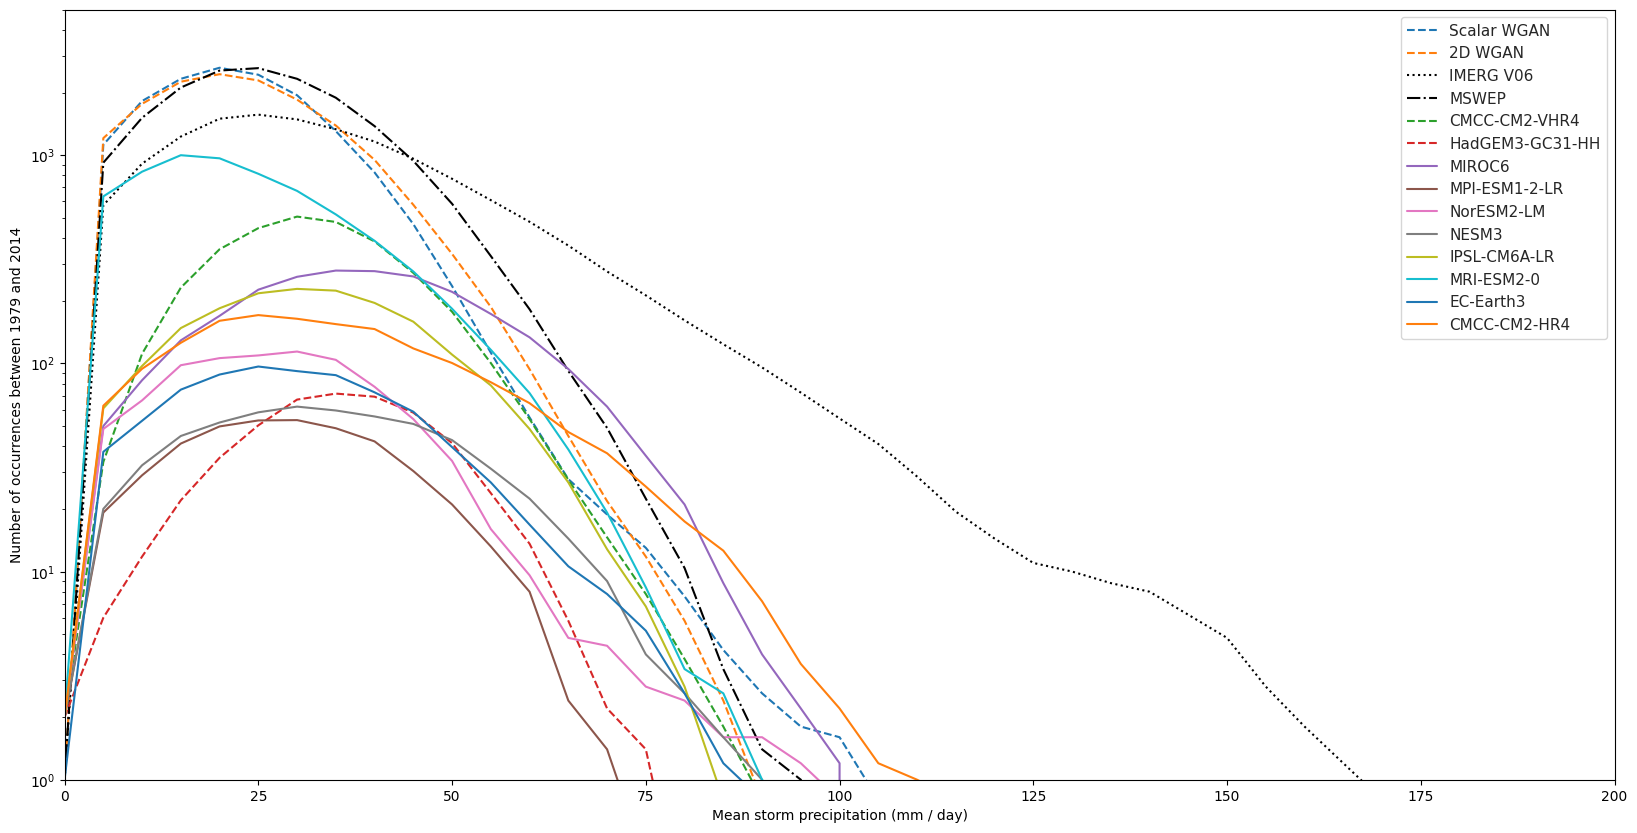

In [28]:

fig,axes = plt.subplots(1,1,figsize=(20, 10))
sns.set(style="whitegrid")
sns.set_palette("Set2")

plt.plot(dates_wgan,total_rain_wgan,linestyle='dashed')
plt.plot(dates_wgan_og,total_rain_wgan_og,linestyle='dashed')

# MSWEP Obs
# im_1 = axes[0,0].plot(total_rain_nh)
# axes[0,0].annotate('Max: %.1f' % np.max(total_rain_nh), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# axes[0,0].annotate('Storms: %.0f' % nstorms_nh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
# # axes[0,0].annotate('Storms per year: %.0f' % (int(nstorms_nh) / nyea), xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
# im_2 = axes[0,1].plot(total_rain_sh)
# axes[0,1].annotate('Max: %.1f' % np.max(total_rain_sh), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# axes[0,1].annotate('Storms: %.0f' % nstorms_sh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
# im_3 = axes[0,2].plot(total_rain_nh_x)
# axes[0,2].annotate('Max: %.1f' % np.max(total_rain_nh_x), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# axes[0,2].annotate('Storms: %.0f' % nstorms_x_nh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')
# im_4 = axes[0,3].plot(total_rain_sh_x)
# axes[0,3].annotate('Max: %.1f' % np.max(total_rain_sh_x), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# axes[0,3].annotate('Storms: %.0f' % nstorms_x_sh, xy = (90,90), xytext=(3,92),fontsize=14, color='#586985')

# IMERG Obs
plt.plot(dates_imerg,total_rain_imerg,color='black',linestyle='dotted')
plt.plot(dates_mswep,total_rain_mswep,color='black',linestyle='dashdot')
# axes[1,0].annotate('Max: %.1f' % np.max(total_rain_imerg_NH), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# im_6 = axes[1,1].plot(total_rain_imerg_SH)
# axes[1,1].annotate('Max: %.1f' % np.max(total_rain_imerg_SH), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')

# im_5b = axes[1,2].plot(imerg_NH)
# axes[1,2].annotate('Max: %.1f' % np.max(imerg_NH), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# im_6b = axes[1,3].plot(imerg_SH)
# axes[1,3].annotate('Max: %.1f' % np.max(imerg_SH), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')

# # TRMM Obs
# im_5 = axes[1,2].plot(total_rain_trmm_NH)
# axes[1,2].annotate('Max: %.1f' % np.max(total_rain_trmm_NH), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# im_6 = axes[1,3].plot(total_rain_trmm_SH)
# axes[1,3].annotate('Max: %.1f' % np.max(total_rain_trmm_SH), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')

# im_5b = axes[1,2].plot(imerg_NH)
# axes[1,2].annotate('Max: %.1f' % np.max(imerg_NH), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# im_6b = axes[1,3].plot(imerg_SH)
# axes[1,3].annotate('Max: %.1f' % np.max(imerg_SH), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')

# HighresMIP
im = axes.plot(dates_CMCC_nh,total_rain_CMCC_nh+total_rain_CMCC_sh,linestyle='dashed')
# axes.plot(dates_CMCC_sh,total_rain_CMCC_sh)

axes.plot(dates_hadgem_nh,total_rain_hadgem_nh + total_rain_hadgem_sh,linestyle='dashed')
# axes.plot(dates_ecearth_nh,total_rain_ecearthhr_nh)
# axes.plot(dates_ecearth_sh,total_rain_ecearthhr_sh)

# CMIP6 hist
axes.plot(dates_miroc6_nh, total_rain_miroc6_nh + total_rain_miroc6_sh)
# axes.plot(dates_miroc6_sh, total_rain_miroc6_sh)

axes.plot(dates_mpi_nh, total_rain_mpi_nh + total_rain_mpi_sh)
# axes.plot(dates_mpi_sh,total_rain_mpi_sh)

axes.plot(dates_noresm_nh,total_rain_noresm_nh + total_rain_noresm_nh)
# im_8c = axes[5,1].plot(total_rain_noresm_sh)

axes.plot(dates_nesm_nh, total_rain_nesm_nh + total_rain_nesm_sh)
# axes.plot(dates_nesm_sh, total_rain_nesm_sh)

axes.plot(dates_ipsl_nh, total_rain_ipsl_nh +total_rain_ipsl_sh)
# axes.plot(dates_ipsl_sh, total_rain_ipsl_sh)

axes.plot(dates_mri_nh, total_rain_mri_nh + total_rain_mri_sh)
# axes.plot(dates_mri_sh, total_rain_mri_sh)

axes.plot(dates_ecearth_nh, total_rain_ecearth_nh)
# axes[7,1].plot(dates_ecearth_sh, total_rain_ecearth_sh)

axes.plot(dates_cmcclr_nh, total_rain_cmcclr_nh + total_rain_cmcclr_sh)
# axes.plot(dates_cmcclr_sh, total_rain_cmcclr_sh)

# plt.plot([0,10,20,30],[0,10,20,30])


# OG WGAN
# im_og_nh = axes[8,0].plot(total_rain_og_nh)
# axes[8,0].annotate('Max: %.1f' % np.max(total_rain_og_nh), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# im_og_sh = axes[8,1].plot(total_rain_og_sh)
# axes[8,1].annotate('Max: %.1f' % np.max(total_rain_og_sh), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# im_og_x_nh = axes[8,2].plot(total_rain_og_x_nh)
# axes[8,2].annotate('Max: %.1f' % np.max(total_rain_og_x_nh), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# im_og_x_sh = axes[8,3].plot(total_rain_og_x_sh)
# axes[8,3].annotate('Max: %.1f' % np.max(total_rain_og_x_sh), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')

# Scalar WGAN
# im_pred_nh = axes[9,0].plot(total_rain_wgan_nh)
# axes[9,0].annotate('Max: %.1f' % np.max(total_rain_wgan_nh), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')
# im_pred_sh = axes[9,1].plot(total_rain_wgan_sh)
# axes[9,1].annotate('Max: %.1f' % np.max(total_rain_wgan_sh), xy = (90,90), xytext=(70,3),fontsize=14, color='#586985')

# Set the tick positions
# t_p = [0,10,20,30,40,50,60,70,80,90,100]
# t_l = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
# for i in range(10):
# 	for j in range(4):
# 		axes[i,j].set_xticks(t_p)
# 		axes[i,j].set_yticks(t_p)
# 		# Set the tick labels
# 		axes[i,j].set_xticklabels(t_l)
# 		axes[i,j].set_yticklabels(t_l)


plt.yscale('log')
plt.ylim(1,5000)
plt.xlim(0,200)
plt.legend(['Scalar WGAN','2D WGAN','IMERG V06','MSWEP','CMCC-CM2-VHR4','HadGEM3-GC31-HH','MIROC6','MPI-ESM1-2-LR','NorESM2-LM','NESM3','IPSL-CM6A-LR','MRI-ESM2-0','EC-Earth3','CMCC-CM2-HR4'])
plt.xlabel('Mean storm precipitation (mm / day)')
plt.ylabel('Number of occurrences between 1979 and 2014')

plt.savefig('3_rain_frequency_hist.png',bbox_inches='tight')